# CatGAN

## Install and Import Dependencies

In [40]:
download = False
if download:
    !git clone https://github.com/DennisRotondi/visiope_project
    !cd visiope_project
    !pip3 install -r requirements.txt

import os
# import cv2
import random
import numpy as np
import torch
from torch import optim, nn, utils, Tensor
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image,ImageOps
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import dataclasses
from dataclasses import dataclass
from dataclasses import asdict
from pprint import pprint
from typing import Sequence, List, Dict, Tuple, Optional, Any, Set, Union, Callable, Mapping

logger = TensorBoardLogger("tb_logs", name="my_model")
%load_ext tensorboard

np.random.seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False
_ = pl.seed_everything(0)

Global seed set to 0


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Dataset Handling

In [51]:
class CatDataset(Dataset):
    
    def __init__(self, 
                 folder, 
                 transform = None
        ):
        
        super().__init__()
        self.folder = Path(folder)
        assert(self.folder.is_dir())
        self.files = list(sorted(self.folder.rglob('*.jpg')))
        assert(self.files)
        self.files_num = len(self.files)
        self.transform = transform


    def __len__(self):
        return self.files_num

    def pil_loader(self,file):
        with file.open('rb') as f:
            img = PIL.Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
        file = self.files[index % self.files_num]
        image = self.pil_loader(file)

        if self.transform is not None:
            image = self.transform(image)
        
        return {
            'file': image,
            'path': str(file)
        }
        
def plot_cats(images, 
                images_per_row, 
                border = 10, 
                pad_value = 1,
                title = 'Cats images'):
    plt.figure(figsize = (16, 16))
    plt.imshow(torchvision.utils.make_grid(images,images_per_row,border,pad_value=pad_value).permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')

visualize some cats from the dataset

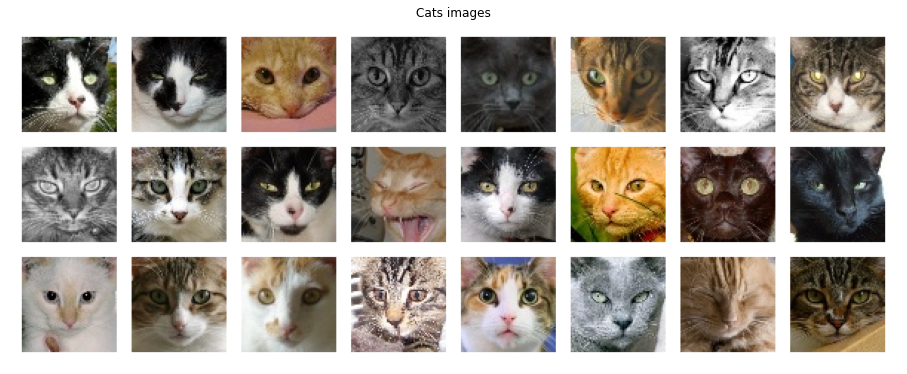

In [52]:
path = "./cats"

catsData = DataLoader(
    CatDataset(
        path,
        transform=transforms.Compose([transforms.ToTensor()])
    ),
    batch_size=24,
    shuffle=True,
)
batch = iter(catsData).next()
plot_cats(batch["file"], images_per_row=8, title="Cats images")

## GAN Model

### Hyperparameters

In [53]:
@dataclass
class Hparams:
    n_epochs: int = 200  # number of epochs of training
    img_height: int = 64  # size of image height # default 256x256
    img_width: int = 64  # size of image width
    batch_size: int = 128  # size of the batches
    lr: float = 0.0002  # adam: learning rate
    channels: int = 3  # number of image channels
    n_residual_blocks: int = 6  # number of residual blocks in generator
    n_cpu: int = 8  # number of cpu threads to use for the dataloaders
    latent_dim: int = 100
hparams = Hparams()
pprint(asdict(hparams))

{'batch_size': 128,
 'channels': 3,
 'img_height': 64,
 'img_width': 64,
 'latent_dim': 100,
 'lr': 0.0002,
 'n_cpu': 8,
 'n_epochs': 200,
 'n_residual_blocks': 6}


In [54]:
class Generator(nn.Module):
    def __init__(self,hparams):
        super(Generator, self).__init__()
        self.hparams = hparams
        self.img_shape = (hparams.channels, hparams.img_height, hparams.img_width)
        
        #built according to this benchmark: https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md
        def gan_block(in_features, out_features, normalize=True):
            layer = [nn.Linear(in_features, out_features)]
            layer.append(nn.PReLU())
            if normalize:
                layer.append(nn.BatchNorm1d(out_features))
            layer.append(nn.Dropout(0.2))
            return layer

        self.model = nn.Sequential(
            *gan_block(self.hparams.latent_dim, 128, normalize=False),
            *gan_block(128, 256),
            *gan_block(256, 512),
            *gan_block(512, 1024),
            nn.Linear(1024, int(np.prod(self.img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self,hparams):
        super(Discriminator, self).__init__()
        self.hparams = hparams
        self.img_shape = (hparams.channels, hparams.img_height, hparams.img_width)
        
        #linear layers to not make discriminator much better than generator (using convolutions it would be really easy to classify bad examples)
        self.layers = nn.Sequential(
            nn.Linear(int(np.prod(self.img_shape)), 2048),
            nn.PReLU(),
            nn.Linear(2048, 1024),
            nn.PReLU(),
            nn.Linear(1024, 512),
            nn.PReLU(),
            nn.Linear(512, 256),
            nn.PReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_linear = img.view(img.size(0), -1)
        img_class = self.layers(img_linear)
        return img_class

class CatGAN(pl.LightningModule):
    def __init__(
        self,
        hparams,
        train_folder):
        super().__init__()
        self.save_hyperparameters(hparams) #Save arguments to ``hparams`` attribute.
        self.train_folder = train_folder
        self.generator = Generator(self.hparams)
        self.discriminator = Discriminator(self.hparams)

        # Image Normalizations
        self.image_transforms = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ]
        )
    def forward(self, x):
        return self.generator(x)

    def train_dataloader(self):
        train_loader = DataLoader(
            CatDataset(
                self.train_folder, transform=self.image_transforms
            ),
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=self.hparams.n_cpu,
            pin_memory=True,
        )
        return train_loader

In [55]:
cg = CatGAN(hparams,path)

ValueError: Unsupported config type of <class '__main__.Hparams'>.